<a href="https://colab.research.google.com/github/eking03/Data110-Fall2025/blob/main/Data110_Final_EmmaKing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

## Importing Libraries

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install contextily


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as cx

## Importing Data

In [2]:
air = pd.read_csv('https://raw.githubusercontent.com/eking03/Data110-Fall2025/refs/heads/main/Data/Air_Quality_Purple_Air_Sensors.csv')

In [3]:
air = air[['SENSOR_INDEX', 'REPORTED_DATETIME', 'HUMIDITY', 'TEMPERATURE', 'PRESSURE', 'PM2_5', 'PM2_5_CF_1', 'PM2_5_ALT', 'VOC', 'LONGITUDE', 'LATITUDE', 'OBJECTID']]

air = air.rename(columns={'PM2_5' : 'PM', 'PM2_5_CF_1' : 'PM_CF1', 'PM2_5_ALT' : 'PM_ALT'})

air['REPORTED_DATETIME'] = air['REPORTED_DATETIME'].str.replace('+00', '')
air['REPORTED_DATETIME'] = air['REPORTED_DATETIME'].str.replace('/', '-')

air['REPORTED_DATETIME'] = pd.to_datetime(air['REPORTED_DATETIME'])

air['MONTH'] = air['REPORTED_DATETIME'].dt.month
air['HOUR'] = air['REPORTED_DATETIME'].dt.hour

In [4]:
sensor_gdf = air[['SENSOR_INDEX', 'LATITUDE', 'LONGITUDE']].groupby(['SENSOR_INDEX']).mean().reset_index()
sensor_gdf = gpd.GeoDataFrame(sensor_gdf, geometry = gpd.points_from_xy(sensor_gdf.LONGITUDE, sensor_gdf.LATITUDE), crs="EPSG:4236")
sensor_gdf = sensor_gdf[['SENSOR_INDEX', 'geometry']]

In [5]:
# air_gdf = gpd.GeoDataFrame(air, geometry = gpd.points_from_xy(air.LONGITUDE, air.LATITUDE), crs="EPSG:4326")
air_gdf = pd.merge(air, sensor_gdf, on='SENSOR_INDEX')
air_gdf = gpd.GeoDataFrame(air_gdf, geometry = air_gdf.geometry, crs="EPSG:4326")

In [6]:
air_gdf = air_gdf[air_gdf['PM_CF1'].notnull()]
air_gdf = air_gdf[air_gdf['TEMPERATURE'] < 150]

In [16]:
dc_shape = gpd.read_file('https://opendata.dc.gov/api/download/v1/items/7241f6d500b44288ad983f0942b39663/shapefile?layers=10')
dc_shape = dc_shape.to_crs('EPSG:3857')

## Air Sensor Maps

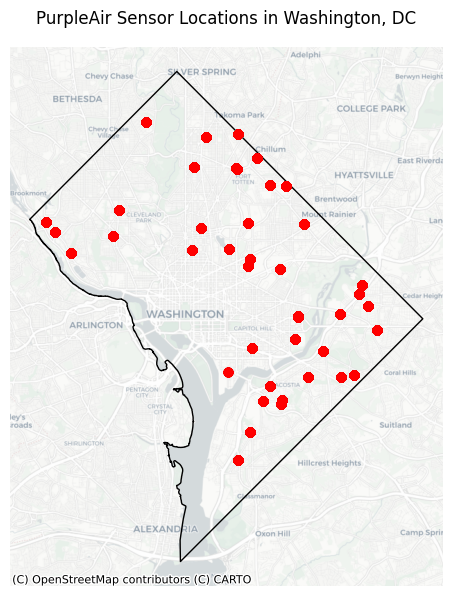

In [69]:
fig, ax = plt.subplots(1, figsize = (7,7))

dc_shape.plot(ax=ax, edgecolor='black', facecolor='none')
air_gdf.to_crs('EPSG:3857').plot(ax=ax, color='red')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
plt.title('PurpleAir Sensor Locations in Washington, DC')
plt.axis('off')
plt.show()

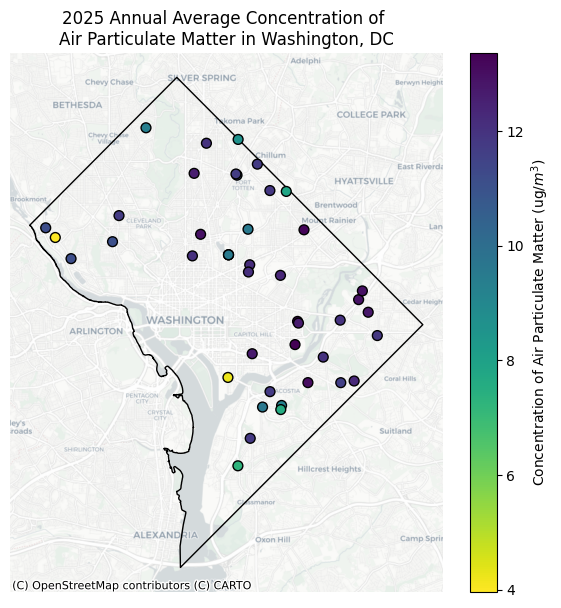

In [68]:
air2 = air_gdf[['SENSOR_INDEX', 'geometry', 'PM']].groupby(['SENSOR_INDEX', 'geometry']).mean().reset_index()
air2 = gpd.GeoDataFrame(air2, geometry = air2.geometry, crs="EPSG:4326")

fig, ax = plt.subplots(1, figsize = (7,7))

dc_shape.plot(ax=ax, edgecolor='black', facecolor='none')
air2.to_crs('EPSG:3857').plot(ax=ax, column='PM',
                              legend=True, legend_kwds={'label':'Concentration of Air Particulate Matter (ug/$m^3$)'},
                              cmap='viridis_r', edgecolor='black', markersize=50)
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
plt.title('2025 Annual Average Concentration of \nAir Particulate Matter in Washington, DC')
plt.axis('off')
plt.show()

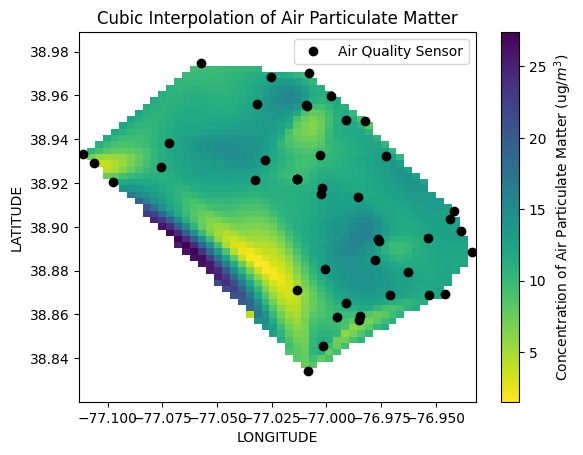

In [54]:
air2['LAT'] = air2.to_crs('EPSG:4326')['geometry'].y
air2['LON'] = air2.to_crs('EPSG:4326')['geometry'].x

# Coding procedure sourced from https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html

from scipy.interpolate import CloughTocher2DInterpolator
import numpy as np
import matplotlib.pyplot as plt

x = air2['LON'].to_numpy()
y = air2['LAT'].to_numpy()
z = air2['PM'].to_numpy()

X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)

plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis_r')
plt.plot(x, y, "ok", label='Air Quality Sensor')
plt.legend(loc="upper right")
cbar = plt.colorbar()
cbar.set_label('Concentration of Air Particulate Matter (ug/$m^3$)')
plt.axis("equal")
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Cubic Interpolation of Air Particulate Matter')
plt.show()

## Air Quality Measurements Over Time

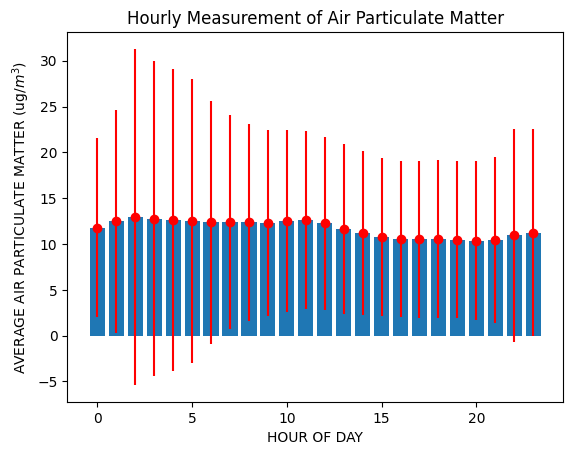

In [58]:
air_hr = air_gdf[['HOUR', 'PM']].groupby(['HOUR'], as_index=False).agg({'PM':['mean', 'std']})
air_hr.columns = ['HOUR', 'PM_mean', 'PM_std']

plt.bar(air_hr['HOUR'], air_hr['PM_mean'])
plt.errorbar(air_hr['HOUR'], air_hr['PM_mean'], yerr=air_hr['PM_std'], fmt="o", color="r")
plt.xlabel('HOUR OF DAY')
plt.ylabel('AVERAGE AIR PARTICULATE MATTER (ug/$m^3$)')
plt.title('Hourly Measurement of Air Particulate Matter')
plt.show()

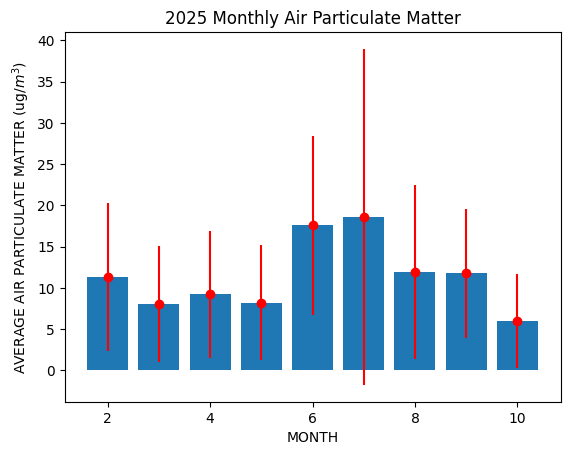

In [64]:
air_mo = air_gdf[['MONTH', 'PM']].groupby(['MONTH'], as_index=False).agg({'PM':['mean', 'std']})
air_mo.columns = ['MONTH', 'PM_mean', 'PM_std']

plt.bar(air_mo['MONTH'], air_mo['PM_mean'])
plt.errorbar(air_mo['MONTH'], air_mo['PM_mean'], yerr=air_mo['PM_std'], fmt="o", color="r")
plt.xlabel('MONTH')
plt.ylabel('AVERAGE AIR PARTICULATE MATTER (ug/$m^3$)')
plt.title('2025 Monthly Air Particulate Matter')
plt.show()

## Meteorological Context

In [ ]:
air_gdf.describe()

,SENSOR_INDEX,REPORTED_DATETIME,HUMIDITY,TEMPERATURE,PRESSURE,PM,PM_CF1,PM_ALT,VOC,LONGITUDE,LATITUDE,OBJECTID,MONTH,HOUR
count,163136.000000,163136,163136.000000,163136.000000,163136.000000,163136.000000,163136.000000,163135.000000,3381.000000,163136.000000,163136.000000,163136.000000,163136.000000,163136.000000
mean,204076.236110,2025-06-30 09:23:15.900353024,48.553845,75.513639,1013.345160,11.694107,12.150887,7.534790,159.870453,-76.998631,38.911571,439099.176368,6.459770,11.467242
min,135676.000000,2025-02-01 05:00:00,5.000000,23.000000,955.070000,0.100000,0.100000,0.100000,51.000000,-77.111206,38.834050,168164.000000,2.000000,0.000000
25%,180847.000000,2025-05-05 03:00:00,36.000000,67.000000,1009.020000,4.500000,4.500000,3.100000,80.000000,-77.009270,38.884618,214941.750000,5.000000,5.000000
50%,218243.000000,2025-06-29 18:00:00,49.000000,77.000000,1013.550000,8.900000,8.900000,5.600000,126.000000,-76.997795,38.914890,513522.500000,6.000000,11.000000
75%,218279.000000,2025-08-28 02:00:00,61.000000,85.000000,1017.780000,16.400000,16.500000,10.100000,192.000000,-76.972820,38.938390,557468.250000,8.000000,17.000000
max,219021.000000,2025-10-29 09:00:00,100.000000,118.000000,1039.660000,518.700000,779.200000,475.800000,751.000000,-76.933080,38.974987,707550.000000,10.000000,23.000000
std,22643.826966,NaN,15.877075,13.680117,6.646097,11.513338,14.940632,8.795546,113.844128,0.042764,0.035962,169254.506624,2.276431,6.934544


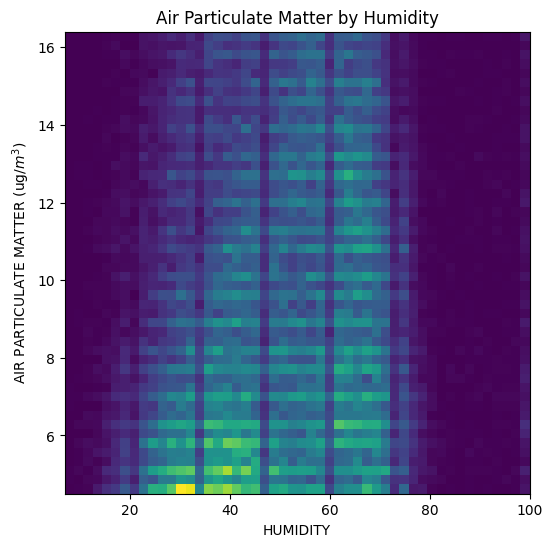

In [62]:
# air_abbrv = air_gdf[air_gdf['PM'] < 50]
air_abbrv = air_gdf[(air_gdf['PM'] <= 16.4) & (air_gdf['PM'] >= 4.5)] #16.4 and 4.5 are the 75th and 25th percentile
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(air_abbrv['HUMIDITY'], air_abbrv['PM'], bins=50)
plt.xlabel('HUMIDITY')
plt.ylabel('AIR PARTICULATE MATTER (ug/$m^3$)')
plt.title('Air Particulate Matter by Humidity')
plt.show()

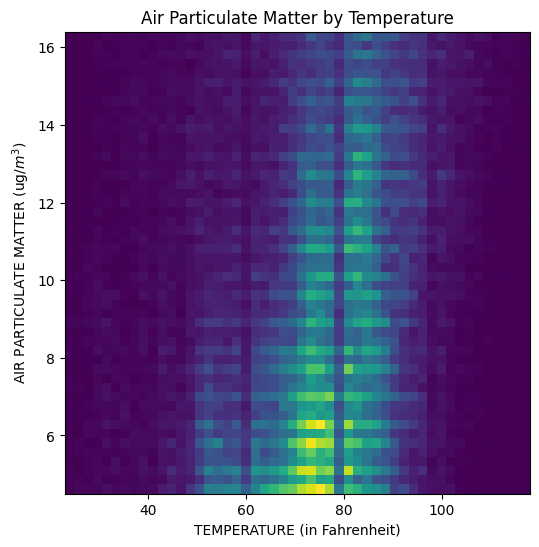

In [61]:
# air_abbrv = air_gdf[air_gdf['PM'] < 50]
air_abbrv = air_gdf[(air_gdf['PM'] <= 16.4) & (air_gdf['PM'] >= 4.5)]
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(air_abbrv['TEMPERATURE'], air_abbrv['PM'], bins=50)
plt.xlabel('TEMPERATURE (in Fahrenheit)')
plt.ylabel('AIR PARTICULATE MATTER (ug/$m^3$)')
plt.title('Air Particulate Matter by Temperature')
plt.show()

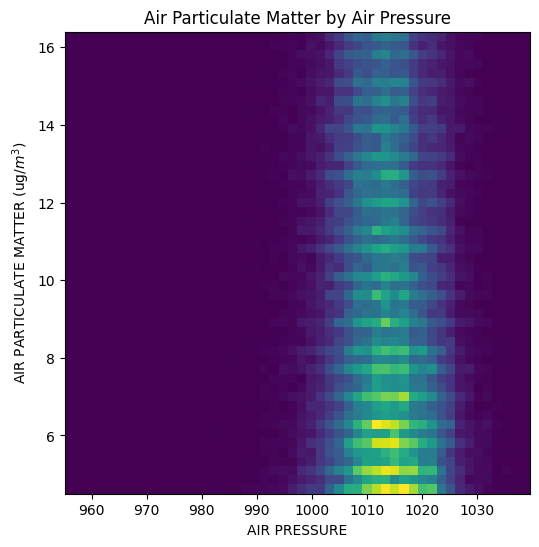

In [60]:
# air_abbrv = air_gdf[air_gdf['PM'] < 50]
air_abbrv = air_gdf[(air_gdf['PM'] <= 16.4) & (air_gdf['PM'] >= 4.5)]
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(air_abbrv['PRESSURE'], air_abbrv['PM'], bins=50)
plt.xlabel('AIR PRESSURE')
plt.ylabel('AIR PARTICULATE MATTER (ug/$m^3$)')
plt.title('Air Particulate Matter by Air Pressure')
plt.show()